# Assignment 1 - Online PCA and Anomaly Detection

## Preamble
### Power PCA

In Lecture 4 and Lab 4 we studied the power method for PCA, which is based on the iterative process
$$\mathbf{w}\leftarrow \mathbf{Rw}, \mathbf{w}\leftarrow\frac{\mathbf{w}}{\|\mathbf{w}\|}$$
that makes $\mathbf{w}$ converge to the (first) eigenvector. 

With progressive deflation of $\mathbf{R}$, multiple eigenvectors can be worked out using the same process.
An implementation of the algorithm is listed as follows for your reference.

The $\mathtt{powerPCA()}$ method returns a matrix $\mathtt{W}$ formed by eigenvectors (as column vectors), and the corresponding eigenvalue array $\mathtt{ev}$.

In [1]:
import numpy as np
import numpy.linalg as LA



# Power method 
def power_iterations(R, w):
    while 1:
        w1=w.copy()
        w=R*w
        w/=LA.norm(w)
        if converged(w, w1):
            break
    return w

# test whether two normalized vectors are the same (or deviation within a threshold) 
def converged(w, w1, thres=1e-10):
    converged=False
    corr=w.T*w1
    #print corr
    if abs(corr)>1-thres:
        converged=True
    return converged

def powerPCA(data, n_pcs):
    nr,dim=data.shape
    X=np.matrix(data)
    m=np.mean(data, axis=0)
    R=(X-m).T*(X-m)/(nr-1.0)
    R0=R.copy()
    
    # initialize
    w=np.matrix(np.random.rand(dim)).T  
    w/=LA.norm(w)
    # iterate for 1st eigenvector
    w=power_iterations(R, w)
    # first eigenvector as first column of W
    W=w
    # iterate for other eigenvectors
    for i in range(1, n_pcs):  
        # deflate R
        R-=w*w.T*R
        # initialize and Power iter
        w=np.matrix(np.random.rand(dim)).T
        w/=LA.norm(w)
        w=power_iterations(R, w)
        # attach the new eigenvector to W as a new column
        W=np.c_[W, w]
    
    # get eigenvalues and save them in the ev array
    y=R0*W
    ev=LA.norm(y,axis=0)/LA.norm(W,axis=0)    
    return W,ev

### Dataset
For this assignment we are using a subset from the Sklearn package's "Digits" dataset. First, we load in the data:

In [2]:
from sklearn import (datasets, decomposition)

digits=datasets.load_digits(n_class=6)
X=digits.data
y=digits.target
n_samp, n_feat = X.shape



The following is a $\mathtt{plot\_embedding()}$ function that displays 2-D data points with their corresponding labels in different colours.

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, labels, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X1 = (X - x_min) / (x_max - x_min)

    plt.figure()
    for i in range(X.shape[0]):
        plt.text(X1[i, 0], X1[i, 1], str(labels[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

Now let's put the code above to use - we project the "digits" dataset using power PCA for visualization. The 2-D projection is simply generated as $\mathtt{prj}=\mathtt{X*W}$.

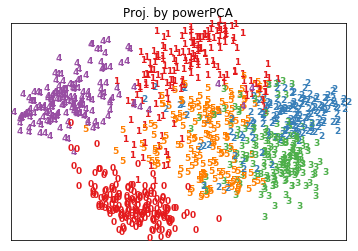

In [4]:
X=np.matrix(X)
m=np.mean(X,axis=0)
X-=m
R=X.T*X/(n_samp-1.0) # why n_samp-1.0 here?? 
W0,ev0=powerPCA(X,n_pcs=2)

batch_w1 = W0[:, 0:1]


batch_prj=X*W0[:,0:2]
plot_embedding(batch_prj, y, "Proj. by powerPCA")






## Task A. Online PCA using modified power method

The $\mathtt{powerPCA}$ method given above carries out PCA in a batch mode, i.e., it needs to gather all data to compute the covariance matrix $\mathbf{R}$, and then the power iterations follow (along with the deflation of $\mathbf{R}$ for each eigenvector obtained). 

The following is an idea about developing an incremental Power method for online analysis of data streams. 

First, use a mini-batch, say the first 100 rows of $\mathbf{X}$ to obtain the mean vector $\mathbf{m}$, and the covariance matrix $\mathbf{R}$ in the same way as in the $\mathtt{powerPCA()}$ method. Now, design an online Power Method algorithm that carries out the following operations:
1. Use the next row of $\mathbf{X}$ as input $\mathbf{x}$, and update the online average $\mathbf{m}$.
2. Use $\mathbf{x}$ to update $\mathbf{R}$ (as an online average of $\mathbf{x}^T\mathbf{x})$.
3. Write an $\mathtt{onlinePowerPCA(R)}$ method that derives the eigenvectors and eigenvalues of
the current $\mathbf{R}$.
4. Repeat the above process until all entries of $\mathbf{X}$ are handled.

Following the idea we introduced in online clustering, we can use the exponential weighting to produce the online average, e.g.
$$\mathbf{m}\leftarrow \gamma\mathbf{m}+ (1-\gamma)\mathbf{x}$$
where $\gamma$ is a weighting coefficient, $0<\gamma\ll 1$. The same idea works for updating $\mathbf{R}$ as well. 

**Task A1**. Use the final $\mathtt{onlinePowerPCA()}$ outcome to visualize the dataset. Compare it with the original visualization obtained by batch PCA. (2 marks)

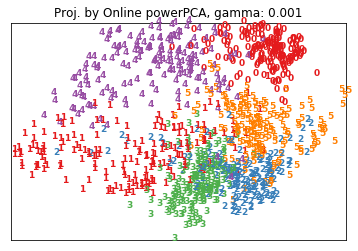

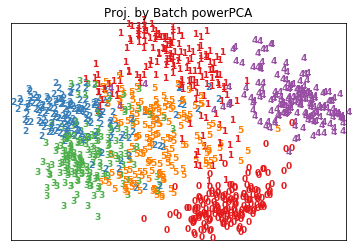

In [21]:



def onlinePowerPCA(R,npc):

    R1=R.copy()
    # initialize vector 
    w=np.matrix(np.random.rand(dim)).T  
    w/=LA.norm(w)
    # iterate for 1st eigenvector
    w=power_iterations(R, w)
    # first eigenvector as first column of W
    W=w
    
    for i in range(1, npc):  
        # deflate R
        R1-=w*w.T*R1
        # initialize and Power iter
        w=np.matrix(np.random.rand(dim)).T
        w/=LA.norm(w)
        w=power_iterations(R1, w)
        # attach the new eigenvector to W as a new column
        W=np.c_[W, w]
    
    y=R*W
    ev=LA.norm(y,axis=0)/LA.norm(W,axis=0)
    return W,ev







"""Initialization: create a mini-batch using 100 entries, compute their mean,m and Covariance matrix,R"""

nr,dim=X.shape
current_batch_size = 100
starting_X=np.matrix(X[:current_batch_size])
m=np.mean(starting_X,axis=0)
starting_X-=m
R=starting_X.T*starting_X/(current_batch_size - 1.0)

# Now we have our initial m and R

# Setting a small gamma value. Note that we use (1-gamma) to weight the old value, and gamma to discount the update.
gamma = 0.001

final_W = None
final_ev = None

W_collection = []



while current_batch_size < nr:

    current_batch_size +=1
    x=np.matrix(X[current_batch_size-1])

    # Make update to mean: we associate 1-gammar with old value
    m = (1-gamma)*m + gamma *x
    
    x-=m

    # incrementally update covariance matrix, R
    R=(1-gamma)*R +  (gamma * (x.T*x))
    
    R_copy = R.copy()
    W0,ev0=onlinePowerPCA(R,npc=2)
    assert np.array_equal(R, R_copy)
    
    # save the first column of W--the first eigen vectors
    W_collection.append(W0[:, 0:1])
    
    if final_W is None:
        final_W,final_ev = W0,ev0
    else:
        final_W = (1-gamma)*final_W + gamma * W0
        final_ev =(1-gamma)*final_ev + gamma * ev0



prj=X*final_W[:,0:2]
plot_embedding(prj, y, "Proj. by Online powerPCA, gamma: " + str(gamma))


plot_embedding(batch_prj, y, "Proj. by Batch powerPCA")





**Task A2**. Examine the first eigenvector obtained by the online algorithm e1, and compare it with the counterpart (w1) obtained through the batch mode in Section 1.1. Calculate their correlation eT1 w1 over time. (1 mark)

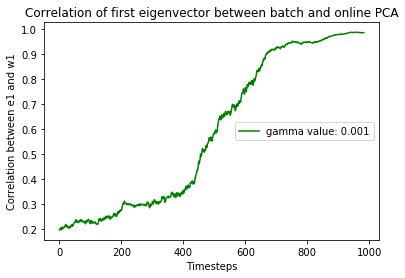

In [22]:
correlation = []

def calc_correlation(w1,w2):
    return abs(w1.T * w2)


for w in W_collection:
    #corr = w.T * batch_w1
    corr = calc_correlation(w,batch_w1)
    correlation.append(np.asscalar(corr))
    
  
    
plt.title('Correlation of first eigenvector between batch and online PCA')
plt.plot(correlation,'-g',label='gamma value: ' + str(gamma))
plt.xlabel("Timesteps")
plt.ylabel("Correlation between e1 and w1")
plt.legend(loc='center right')
plt.show()    




#for i in range(0,len(correlation)):
 #   print  "timestep ", i, " correlation between e1 and w1", correlation[i]
    #print correlation[i]
    
    




**Task A3**. Present and comment on your findings in the report. (2 marks)

Gamma rate makes a significant difference to the stability of the incremental PCA. The lower the gamma values,the more weights are associated towards the old values when making incremental update and vice versa.

The result of this is evident when visualizing the correlation between the eigenvector of batch mode PCA and incremental PCA. When gamma is high, the correlation value fluctuate significantly, when gamma is lower (around 0.001), the correlation steadily increase and converge near 1.0. 

This makes sense, as when more weighting is given to the new update, the principle component would be more sensitives to change introduced by the new data point arriving. Whereas, in the opposite case, the principle component changes at a much more steady rate. 

Conceptually, this as somewhat similar to step size in gradient descent, where we do not want to have gamma so large that we "overshoot" and do not converge. 


When it comes to visualizing the results, it appears that shifts in gamma value makes an insignificant impact on the clustering quality. The clustering outcome using gamma ranged from 0.1-0.001 all shows a good level of seperation between classes (perhaps some slightly better than others). 



## Task B. Incremental Power PCA for outlier detection

## Online PCA can be used as an effective tool for stream data outlier detection. Our following
adventure is based on an idea from "Anomaly detection via online oversampling principal
component analysis", by Lee et al., TKDE 25:7. You do not have to read the paper in order to complete
this assignment.

Randomly extract 100 data instances that belong to the "0" class and construct the initial $\mathtt{R}$ matrix.
Carry out batch power PCA and obtain the first eigenvector $\mathtt{e}$.

What follows is we will take a new data point x, and use it to calculate a new covariance matrix
$\mathtt{R1}$ based on $\mathtt{R}$. After obtaining its first eigenvector, denoted by $\mathtt{e1}$, we correlate it with the original eigenvector $\mathtt{e}$. It is expected that a "0" class data point will produce an eigenvector
strongly correlated to $\mathtt{e}$ (with correlation close to 1), while data points of other classes will produce significant deviations (i.e. with correlation dropping toward 0). Hence we can use  a threshold to "test" on each data sample and decide whether it is an outlier.  

Note you'll need to keep a copy of the old $\mathtt{R}$ as it is needed for each test. 

To evaluate this outlier detection scheme, we iterate through the entire dataset:
1. Pick the next data point $\mathtt{x}$.
2. Call $\mathtt{onlinePowerPCA()}$ and obtain the first eigenvector $\mathtt{e1}$.
3. Calculate the correlation between the old and new eigenvectors $\mathtt{e}$ and $\mathtt{e1}$: $\mathtt{corr=e.T*e1}$.
4. Use a threshold on 'corr' so as to decide whether the current input is an outlier.
5. Compare the result with the class labels ($\mathtt{y}$) and collect error statistics such as true positive rate (TPR) and false positive rate (FPR).


**Task B1**. Complete the outlier detection implementation outlined as above; use gamma=0.05 to test it. (2 marks)

In [23]:


def outlier_detector(i_batchsize,gamma):
    
    # randomly sample 100 0-labeled data points
    initial_batch = None
    
    count = 0
    
    ground_truth = []
    corr_values = []
    prediction = []

    while count < i_batchsize:
        index = np.random.randint(n_samp)
       
        if y[index] == 0:
            count+=1
            if initial_batch is None:
                initial_batch = X[index]
            else:
                initial_batch=np.r_[initial_batch,X[index]]


    # initialize the first eigenvector and eigenvalue based on the random sampling.
    m=np.mean(initial_batch,axis=0)
    initial_batch-=m
    initial_R = initial_batch.T*initial_batch/(i_batchsize-1.0)

    
    #ibatch = initial_batch.copy()
    w0,ev0 = powerPCA(initial_batch, 2)
    w0 = w0[:, 0:1]


    for i in range (0,n_samp):
        sample = X[i]
        label = y[i]
        pred = 0

        curr_x = np.matrix(sample)
        curr_m = (1-gamma) * m + gamma * curr_x
        #curr_x -= curr_m
        curr_R = (1-gamma) * initial_R + gamma * ((curr_x-m).T * (curr_x-m))

        #curr_R_copy = curr_R.copy()
        curr_w,curr_ev = onlinePowerPCA(curr_R,2)
        
        curr_w = curr_w[:, 0:1]
       # assert np.array_equal(curr_R_copy, curr_R)
        corr = np.asscalar(calc_correlation(w0,curr_w))        
        
        ground_truth.append(label)
        corr_values.append(corr)
 
        
        #print "label ", label, " corr to class zero ", corr, "outlier ", outlier
        
        
    return ground_truth,corr_values
      



def predictor(threshold, correlation):
    prediction = []
    
    for corr in correlation:
        pred = corr > threshold
        prediction.append(pred)
    return prediction

        

In [24]:

    
        
def validator (ground_truth, predictions ,verbose=0):
    """ Tester function,computes TPR and FPR, verbose level defaults to 0, set it to 1 to see the output of 
    validation, set it to 2 to inspect the correlation vector.
    
    """
    
    
   
    true_positive = 0
    false_positive = 0 
    
    condition_positive = 0
    condition_negative = 0


    for i in range (0,len(ground_truth)):
        if verbose == 2:
            print "label ", ground_truth[i], "prediction: ", predictions[i]

        # Counting up the conditional positive for true outliers
        if ground_truth[i] == 0:
            condition_positive += 1
            
            if predictions[i] == True:
                #print "FOUND! "
                true_positive +=1
                #print "label ", ground_truth[i], " corr to class zero ", corr_vales[i], "outlier? ", predictions[i]
           
        else:  
            condition_negative += 1
            if predictions[i] == True:
                false_positive+=1
         

    

    FPR = false_positive / np.float(condition_negative)   
    TPR = true_positive /  np.float(condition_positive)
   # FPR = false_positive / np.float(false_positive + true_negative)   
   # TPR = true_positive /  np.float(true_positive + false_negative)
    

    if verbose==1:
        print "gamma: ", gamma
        print "threshold: ", threshold
        print "Total entries: ", len(ground_truth)
        print "Condional negatives", condition_negative
        print "Conditioal positives", condition_positive
        print "false positives: ", false_positive
        print "true positive: ", true_positive, "\n"
        print "TPR", TPR
        print "FPR", FPR, "\n"

    return TPR,FPR




gamma = 0.05
threshold = 0.1
batchsize = 100

        

y_true, corr = outlier_detector(batchsize,gamma)
prediction = predictor(threshold,corr)
TPR,FPR = validator(y_true, prediction, verbose=1)




gamma:  0.05
threshold:  0.1
Total entries:  1083
Condional negatives 905
Conditioal positives 178
false positives:  825
true positive:  178 

TPR 1.0
FPR 0.911602209945 



**Task B2**. Experiment with different different $\gamma$ and threshold values in the algorithm, and plot the TPR-FPR curves. (1 mark)

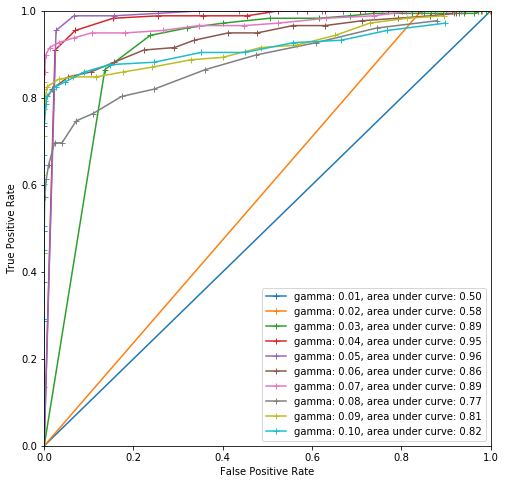

In [25]:
from sklearn import metrics

batchsize = 100
TPR_list = []
FPR_list = []
gammas = []
auc = []

gamma = 0.01

for i in range (0,10):
    threshold = 0
    TPR = []
    FPR = []
    y_true, corr = outlier_detector(batchsize,gamma)

    for j in range(0,20):
        threshold += 0.05
        prediction = predictor(threshold,corr)
        tpr,fpr = validator(y_true, prediction, verbose=0)
        TPR.append(tpr)
        FPR.append(fpr)
        
    auc.append(metrics.auc(FPR, TPR))
    TPR_list.append(TPR)
    FPR_list.append(FPR)
    gammas.append(gamma)
    gamma += 0.01
    


    
    
plt.figure(figsize=(8,8))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])  

legend_entry = []
 
for i in range (0,len(FPR_list)):
    plt.plot(FPR_list[i], TPR_list[i],"-+")
    legend_entry.append("gamma: %0.2f" % gammas[i] + ", area under curve: %0.2f" % auc[i])
    

plt.legend(legend_entry, loc='lower right')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show() 




**Task B3**. Work out and report the Area Under the Curve (AUC) value. (1 mark)

In [26]:

# Calculation is already done on previous cell, just printing out the results again. 

for i in range (0,len(FPR_list)):
    print ("gamma: %f" % gammas[i] + " area under curve: %0.2f" % auc[i])
    




gamma: 0.010000 area under curve: 0.50
gamma: 0.020000 area under curve: 0.58
gamma: 0.030000 area under curve: 0.89
gamma: 0.040000 area under curve: 0.95
gamma: 0.050000 area under curve: 0.96
gamma: 0.060000 area under curve: 0.86
gamma: 0.070000 area under curve: 0.89
gamma: 0.080000 area under curve: 0.77
gamma: 0.090000 area under curve: 0.81
gamma: 0.100000 area under curve: 0.82


**Task B4**. Present and comment on your findings in the report. (1 mark)

**Context:**

for this section, I plotted the ROC based on an increment of gamma value. Each line on the graph represents a gamma value between 0.01-0.1, incrementing by a value of 0.01 each time. 

Each point on the line represents a change in threshold value. Each line contains 20 points, with threshold value ranging from 0-1, incrementing by 0.05 each time. 


**Findings and comments:**

Given a fixed range of threshold, as the gamma value increases, the accuracy of the classification increases. The Area Under Curve increases in proportional with the gamma value. In other words, higher gamma result in better classification
    
This is because we make classification based on the correlation of the first eigenvetor between the original training data(the initial batch of 100 inliers), and each new data point as it arrives. With a higher gamma value, the eigenvector will be more sensitive to deviation introduced by the new data point. Therefore the correlation between the new and old eigenvector would go down (because they are now less similar). 
    
Comparitively, if the gamma is smaller, then new eigenvector would deviate less from the old eigenvector, making the classification process less accurate, given the current range of threshold values used. One way around this problem is to scale the threshold value accordingly as a function of the gamma value. 

